# Setup and Data Loading
Import required libraries (tensorflow, numpy, PIL), set random seeds, and load the generated CAPTCHA images from directories. Create a dataset mapping labels to image data.

In [1]:
# Run this cell first to check dataset integrity
import os
dataset_path = '/kaggle/input/hard-data-set-precog/hard_variations_dataset'

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset directory {dataset_path} does not exist!")

num_classes = len(os.listdir(dataset_path))
print(f"Found {num_classes} class directories")

total_samples = 0
for class_dir in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_dir)
    num_images = len([f for f in os.listdir(class_path) if f.endswith('.png')])
    print(f"{class_dir}: {num_images} images")
    total_samples += num_images

print(f"\nTotal samples: {total_samples}")

Found 100 class directories
EhaRC: 200 images
oaRecavrQ: 200 images
EshjBcIIF: 200 images
rwstuRSKX: 200 images
kEGom: 200 images
bVsDAaEAg: 200 images
hoeYCHl: 200 images
ExRGgcQm: 200 images
nxArgZ: 200 images
JyNbaaiES: 200 images
ktrhys: 200 images
EKmZRMMFdj: 200 images
QIUND: 200 images
LeTiwxg: 200 images
fNEGDc: 200 images
RMuMaIB: 200 images
pPQiOapFnO: 200 images
sbkimN: 200 images
xfSeosFcJ: 200 images
CBdsWlaNZ: 200 images
FZrMTCh: 200 images
liOByT: 200 images
vokIiGey: 200 images
QZYvWnDrtj: 200 images
mzcoF: 200 images
yDTjR: 200 images
zfWywj: 200 images
OwZLUFE: 200 images
cIVYxO: 200 images
XDJyTa: 200 images
bktrYmm: 200 images
gKWtvSr: 200 images
okKbYVYKgK: 200 images
HuQVCL: 200 images
LymxFOhTE: 200 images
MKLhDzlkS: 200 images
oaFzE: 200 images
aVYBL: 200 images
sGrmXCe: 200 images
FxaoVuvCu: 200 images
DmhwhLovpM: 200 images
OLyaLXAN: 200 images
sGNKl: 200 images
MfCFJlyUqF: 200 images
TsKgnVmt: 200 images
ACowzEqN: 200 images
RdsvprRVVW: 200 images
sOkVZYx: 20

In [2]:
# Setup and imports
!pip install torch torchvision scikit-learn Pillow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import matplotlib as plt

# Set random seeds
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset class
class FixedCaptchaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Get case-insensitive directory list
        self.classes = sorted({name.upper() for name in os.listdir(root_dir)})
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        # Map case-insensitive class names to actual directory names
        dir_mapping = {name.upper(): name for name in os.listdir(root_dir)}
        
        for cls in self.classes:
            actual_dir = os.path.join(root_dir, dir_mapping[cls])
            if not os.path.isdir(actual_dir):
                continue
                
            for img_name in os.listdir(actual_dir):
                if img_name.endswith('.png'):
                    self.images.append(os.path.join(actual_dir, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load data function
def get_data_splits(dataset, test_size=0.2, val_size=0.25, random_state=42):
    indices = list(range(len(dataset)))
    
    # First split: train+val vs test
    train_val_idx, test_idx = train_test_split(
        indices, test_size=test_size, 
        stratify=dataset.labels, random_state=random_state
    )
    
    # Second split: train vs val
    train_idx, val_idx = train_test_split(
        train_val_idx, test_size=val_size/(1-test_size), 
        stratify=[dataset.labels[i] for i in train_val_idx], 
        random_state=random_state
    )
    
    return train_idx, val_idx, test_idx
    
train_transform = transforms.Compose([
    transforms.Resize((128, 64)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load the data with parameters
# dataset_path = '/kaggle/input/hard-data-set-precog/hard_variations_dataset'
# data, labels, label_names, label_to_idx = load_data(dataset_path)

# # Normalize the image data
# data = data / 255.0

# # Print the shape of the data and labels
# print(f'Data shape: {data.shape}')
# print(f'Labels shape: {labels.shape}')

# Data Preprocessing
Convert images to numpy arrays, normalize pixel values, encode labels, and prepare data for training. Resize images to consistent dimensions and convert to grayscale if needed.

In [9]:
# # Data preprocessing
# def preprocess_data(data):
#     # Convert to grayscale and normalize
#     data_gray = []
#     for img in data:
#         # Convert float array back to uint8 for PIL
#         img_uint8 = (img * 255).astype(np.uint8)
#         # Convert to grayscale
#         gray = np.array(Image.fromarray(img_uint8).convert('L'))
#         data_gray.append(gray)
    
#     # Convert to numpy array and normalize
#     data_gray = np.array(data_gray) / 255.0
#     # Add channel dimension for PyTorch (N, C, H, W)
#     data_gray = np.expand_dims(data_gray, axis=1)
    
#     return data_gray

# # Process the data
# data_gray = preprocess_data(data)

# # Create dataset and dataloaders
# dataset = CaptchaDataset(data_gray, labels)
# train_size = int(0.8 * len(dataset))
# valid_size = len(dataset) - train_size
# train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=32)

# # Print shapes to verify
# print(f'Grayscale data shape: {data_gray.shape}')


Grayscale data shape: (5000, 1, 64, 128)


# Build CNN Model
Create a CNN model using tf.keras with multiple convolutional layers, max pooling, dropout for regularization, and dense layers. The final layer should have 100 units with softmax activation.

# Mark1 
## simple CNN model with bath norm and dropout

In [12]:
class CaptchaClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CaptchaClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Increasing the size of the layers

# Final Model

In [17]:
class ImprovedCaptchaClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Input: 3x128x64
            nn.Conv2d(3, 64, 5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 64x64x32
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 128x32x16
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),  # 256x16x8
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [18]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 100
batch_size = 32  # Reduced for better gradient estimation
num_epochs = 50   # Allow more training time

# Load Dataset
try:
    full_dataset = FixedCaptchaDataset(root_dir='/kaggle/input/hard-data-set-precog/hard_variations_dataset', transform=None)
    print(f"Successfully loaded dataset with {len(full_dataset)} samples")
except Exception as e:
    print(f"Dataset loading failed: {str(e)}")
    raise

# Only proceed if dataset is loaded
if len(full_dataset) == 0:
    raise ValueError("Dataset is empty! Check your data generation and directory structure")

#full_dataset = CaptchaDataset(root_dir='/kaggle/input/hard-data-set-precog/hard_variations_dataset', transform=None)
train_idx, val_idx, test_idx = get_data_splits(full_dataset)

Successfully loaded dataset with 20000 samples


In [19]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [20]:
train_subset = TransformedSubset(Subset(full_dataset, train_idx), train_transform)
val_subset = TransformedSubset(Subset(full_dataset, val_idx), val_test_transform)
test_subset = TransformedSubset(Subset(full_dataset, test_idx), val_test_transform)

# Data Loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize Model
model =  CaptchaClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Training Loop
num_epochs = 30
best_val_acc = 0.0

# Final paramas

In [23]:
train_subset = TransformedSubset(Subset(full_dataset, train_idx), train_transform)
val_subset = TransformedSubset(Subset(full_dataset, val_idx), val_test_transform)
test_subset = TransformedSubset(Subset(full_dataset, test_idx), val_test_transform)

# Data Loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize Model
model =  ImprovedCaptchaClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                        steps_per_epoch=len(train_loader),
                                        epochs=num_epochs)

# Training Loop
num_epochs = 30
best_val_acc = 0.0

Class distribution: {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200, 10: 200, 11: 200, 12: 200, 13: 200, 14: 200, 15: 200, 16: 200, 17: 200, 18: 200, 19: 200, 20: 200, 21: 200, 22: 200, 23: 200, 24: 200, 25: 200, 26: 200, 27: 200, 28: 200, 29: 200, 30: 200, 31: 200, 32: 200, 33: 200, 34: 200, 35: 200, 36: 200, 37: 200, 38: 200, 39: 200, 40: 200, 41: 200, 42: 200, 43: 200, 44: 200, 45: 200, 46: 200, 47: 200, 48: 200, 49: 200, 50: 200, 51: 200, 52: 200, 53: 200, 54: 200, 55: 200, 56: 200, 57: 200, 58: 200, 59: 200, 60: 200, 61: 200, 62: 200, 63: 200, 64: 200, 65: 200, 66: 200, 67: 200, 68: 200, 69: 200, 70: 200, 71: 200, 72: 200, 73: 200, 74: 200, 75: 200, 76: 200, 77: 200, 78: 200, 79: 200, 80: 200, 81: 200, 82: 200, 83: 200, 84: 200, 85: 200, 86: 200, 87: 200, 88: 200, 89: 200, 90: 200, 91: 200, 92: 200, 93: 200, 94: 200, 95: 200, 96: 200, 97: 200, 98: 200, 99: 200}
Sample label: CIVYXO


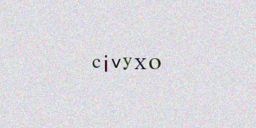

In [8]:
# Diagnostic checks
def verify_data_pipeline():
    # Check label distribution
    unique, counts = np.unique(full_dataset.labels, return_counts=True)
    print(f"Class distribution: {dict(zip(unique, counts))}")
    
    # Visualize samples
    sample_idx = np.random.choice(len(full_dataset))
    img, label = full_dataset[sample_idx]
    print(f"Sample label: {full_dataset.classes[label]}")
    display(img.resize((256, 128)))  # For Jupyter display

verify_data_pipeline()

# Train Model
Compile the model with appropriate loss function (categorical_crossentropy), optimizer (Adam), and metrics. Train the model on the preprocessed data with proper batch size and epochs.

In [21]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    if epoch == 0:
        for g in optimizer.param_groups:
            g['lr'] = 0.0001
    scaler = torch.cuda.amp.GradScaler()
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # for inputs, labels in train_loader:
    #     inputs, labels = inputs.to(device), labels.to(device)
        
    #     optimizer.zero_grad()
        
    #     with torch.cuda.amp.autocast():
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
        
    #     scaler.scale(loss).backward()
    #     scaler.step(optimizer)
    #     scaler.update()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
        
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val
        
        # Update scheduler
        # scheduler.step(val_loss)
        
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')
    # scheduler.step()
        # Save best model
    if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'mark1_model.pth')
            print('Saved best model!')

<ipython-input-21-857755d6a64c>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/30 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s]


Epoch 1/30:
Train Loss: 4.6339 | Acc: 0.0111
Val Loss: 4.6047 | Acc: 0.0108
Saved best model!


Epoch 2/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.95it/s]


Epoch 2/30:
Train Loss: 4.6073 | Acc: 0.0111
Val Loss: 4.6019 | Acc: 0.0108


Epoch 3/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.65it/s]


Epoch 3/30:
Train Loss: 4.5964 | Acc: 0.0120
Val Loss: 4.5602 | Acc: 0.0122
Saved best model!


Epoch 4/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 19.84it/s]


Epoch 4/30:
Train Loss: 4.5094 | Acc: 0.0171
Val Loss: 4.3340 | Acc: 0.0258
Saved best model!


Epoch 5/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.06it/s]


Epoch 5/30:
Train Loss: 4.2999 | Acc: 0.0234
Val Loss: 4.0679 | Acc: 0.0288
Saved best model!


Epoch 6/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.31it/s]


Epoch 6/30:
Train Loss: 4.1277 | Acc: 0.0267
Val Loss: 3.8684 | Acc: 0.0424
Saved best model!


Epoch 7/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.24it/s]


Epoch 7/30:
Train Loss: 4.0229 | Acc: 0.0285
Val Loss: 3.7680 | Acc: 0.0456
Saved best model!


Epoch 8/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.83it/s]


Epoch 8/30:
Train Loss: 3.9561 | Acc: 0.0281
Val Loss: 3.6980 | Acc: 0.0446


Epoch 9/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.42it/s]


Epoch 9/30:
Train Loss: 3.8924 | Acc: 0.0344
Val Loss: 3.6380 | Acc: 0.0484
Saved best model!


Epoch 10/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.63it/s]


Epoch 10/30:
Train Loss: 3.8515 | Acc: 0.0335
Val Loss: 3.5757 | Acc: 0.0616
Saved best model!


Epoch 11/30 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.51it/s]


Epoch 11/30:
Train Loss: 3.8118 | Acc: 0.0380
Val Loss: 3.7035 | Acc: 0.0400


Epoch 12/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.38it/s]


Epoch 12/30:
Train Loss: 3.7770 | Acc: 0.0393
Val Loss: 3.5087 | Acc: 0.0656
Saved best model!


Epoch 13/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s]


Epoch 13/30:
Train Loss: 3.7527 | Acc: 0.0411
Val Loss: 3.4828 | Acc: 0.0644


Epoch 14/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.10it/s]


Epoch 14/30:
Train Loss: 3.7251 | Acc: 0.0396
Val Loss: 3.4584 | Acc: 0.0648


Epoch 15/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.11it/s]


Epoch 15/30:
Train Loss: 3.6989 | Acc: 0.0412
Val Loss: 3.4527 | Acc: 0.0554


Epoch 16/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.40it/s]


Epoch 16/30:
Train Loss: 3.6452 | Acc: 0.0460
Val Loss: 3.5009 | Acc: 0.0572


Epoch 17/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.81it/s]


Epoch 17/30:
Train Loss: 3.6418 | Acc: 0.0448
Val Loss: 3.4047 | Acc: 0.0736
Saved best model!


Epoch 18/30 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.32it/s]


Epoch 18/30:
Train Loss: 3.6104 | Acc: 0.0507
Val Loss: 3.4015 | Acc: 0.0660


Epoch 19/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Epoch 19/30:
Train Loss: 3.5984 | Acc: 0.0487
Val Loss: 3.3170 | Acc: 0.0794
Saved best model!


Epoch 20/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.65it/s]


Epoch 20/30:
Train Loss: 3.5669 | Acc: 0.0533
Val Loss: 3.4328 | Acc: 0.0650


Epoch 21/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.99it/s]


Epoch 21/30:
Train Loss: 3.5555 | Acc: 0.0536
Val Loss: 3.2864 | Acc: 0.0780


Epoch 22/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.47it/s]


Epoch 22/30:
Train Loss: 3.5320 | Acc: 0.0543
Val Loss: 3.2406 | Acc: 0.0858
Saved best model!


Epoch 23/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.93it/s]


Epoch 23/30:
Train Loss: 3.5196 | Acc: 0.0539
Val Loss: 3.2270 | Acc: 0.0914
Saved best model!


Epoch 24/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.12it/s]


Epoch 24/30:
Train Loss: 3.5124 | Acc: 0.0575
Val Loss: 3.2482 | Acc: 0.0960
Saved best model!


Epoch 25/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.91it/s]


Epoch 25/30:
Train Loss: 3.5054 | Acc: 0.0609
Val Loss: 3.1741 | Acc: 0.1086
Saved best model!


Epoch 26/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.28it/s]


Epoch 26/30:
Train Loss: 3.4601 | Acc: 0.0660
Val Loss: 3.1690 | Acc: 0.1038


Epoch 27/30 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.42it/s]


Epoch 27/30:
Train Loss: 3.4501 | Acc: 0.0686
Val Loss: 3.1183 | Acc: 0.1202
Saved best model!


Epoch 28/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.61it/s]


Epoch 28/30:
Train Loss: 3.4254 | Acc: 0.0705
Val Loss: 3.1240 | Acc: 0.1272
Saved best model!


Epoch 29/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.82it/s]


Epoch 29/30:
Train Loss: 3.4105 | Acc: 0.0745
Val Loss: 3.1318 | Acc: 0.1028


Epoch 30/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.88it/s]

Epoch 30/30:
Train Loss: 3.3717 | Acc: 0.0815
Val Loss: 2.9644 | Acc: 0.1608
Saved best model!


# Final 

In [24]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    if epoch == 0:
        for g in optimizer.param_groups:
            g['lr'] = 0.0001
    scaler = torch.cuda.amp.GradScaler()
    # for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
    #     inputs, labels = inputs.to(device), labels.to(device)
        
    #     optimizer.zero_grad()
    #     outputs = model(inputs)
    #     loss = criterion(outputs, labels)
    #     loss.backward()
    #     optimizer.step()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
        
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val
        
        # Update scheduler
        # scheduler.step(val_loss)
        
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')
    scheduler.step()
        # Save best model
    if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print('Saved best model!')

<ipython-input-24-96f8b134c967>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-24-96f8b134c967>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 19.68it/s]

Epoch 1/30:
Train Loss: 4.7636 | Acc: 0.0136
Val Loss: 4.5536 | Acc: 0.0148
Saved best model!



Epoch 2/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.49it/s]

Epoch 2/30:
Train Loss: 4.5101 | Acc: 0.0201
Val Loss: 4.1954 | Acc: 0.0364
Saved best model!



Epoch 3/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.63it/s]

Epoch 3/30:
Train Loss: 4.2960 | Acc: 0.0279
Val Loss: 4.0309 | Acc: 0.0416
Saved best model!



Epoch 4/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.47it/s]

Epoch 4/30:
Train Loss: 4.1751 | Acc: 0.0367
Val Loss: 3.8868 | Acc: 0.0728
Saved best model!



Epoch 5/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.62it/s]

Epoch 5/30:
Train Loss: 4.0212 | Acc: 0.0483
Val Loss: 3.6954 | Acc: 0.1024
Saved best model!



Epoch 6/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.86it/s]

Epoch 6/30:
Train Loss: 3.8034 | Acc: 0.0724
Val Loss: 3.3665 | Acc: 0.1628
Saved best model!



Epoch 7/30 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.58it/s]

Epoch 7/30:
Train Loss: 3.4877 | Acc: 0.1303
Val Loss: 2.8606 | Acc: 0.3066
Saved best model!



Epoch 8/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]

Epoch 8/30:
Train Loss: 3.1043 | Acc: 0.2068
Val Loss: 2.3205 | Acc: 0.4558
Saved best model!



Epoch 9/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.82it/s]

Epoch 9/30:
Train Loss: 2.6133 | Acc: 0.3335
Val Loss: 1.8066 | Acc: 0.5888
Saved best model!



Epoch 10/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.85it/s]

Epoch 10/30:
Train Loss: 2.1686 | Acc: 0.4574
Val Loss: 1.2857 | Acc: 0.7512
Saved best model!



Epoch 11/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.76it/s]

Epoch 11/30:
Train Loss: 1.7463 | Acc: 0.5726
Val Loss: 0.9320 | Acc: 0.8284
Saved best model!



Epoch 12/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.79it/s]


Epoch 12/30:
Train Loss: 1.3755 | Acc: 0.6785
Val Loss: 0.6013 | Acc: 0.9060
Saved best model!


Epoch 13/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.56it/s]


Epoch 13/30:
Train Loss: 1.0935 | Acc: 0.7575
Val Loss: 0.4541 | Acc: 0.9300
Saved best model!


Epoch 14/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 21.01it/s]

Epoch 14/30:
Train Loss: 0.8757 | Acc: 0.8064
Val Loss: 0.3286 | Acc: 0.9496
Saved best model!



Epoch 15/30 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]

Epoch 15/30:
Train Loss: 0.7111 | Acc: 0.8431
Val Loss: 0.2360 | Acc: 0.9702
Saved best model!



Epoch 16/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 19.77it/s]

Epoch 16/30:
Train Loss: 0.5956 | Acc: 0.8757
Val Loss: 0.1783 | Acc: 0.9746
Saved best model!



Epoch 17/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.76it/s]

Epoch 17/30:
Train Loss: 0.4942 | Acc: 0.8977
Val Loss: 0.1453 | Acc: 0.9806
Saved best model!



Epoch 18/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.73it/s]

Epoch 18/30:
Train Loss: 0.4333 | Acc: 0.9089
Val Loss: 0.1298 | Acc: 0.9804



Epoch 19/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.69it/s]


Epoch 19/30:
Train Loss: 0.3791 | Acc: 0.9197
Val Loss: 0.1003 | Acc: 0.9884
Saved best model!


Epoch 20/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.41it/s]

Epoch 20/30:
Train Loss: 0.3149 | Acc: 0.9369
Val Loss: 0.0823 | Acc: 0.9902
Saved best model!



Epoch 21/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.74it/s]

Epoch 21/30:
Train Loss: 0.2820 | Acc: 0.9419
Val Loss: 0.0645 | Acc: 0.9916
Saved best model!



Epoch 22/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.45it/s]

Epoch 22/30:
Train Loss: 0.2515 | Acc: 0.9471
Val Loss: 0.0524 | Acc: 0.9940
Saved best model!



Epoch 23/30 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s]

Epoch 23/30:
Train Loss: 0.2227 | Acc: 0.9560
Val Loss: 0.0487 | Acc: 0.9934



Epoch 24/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.35it/s]


Epoch 24/30:
Train Loss: 0.2001 | Acc: 0.9577
Val Loss: 0.0395 | Acc: 0.9946
Saved best model!


Epoch 25/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.87it/s]

Epoch 25/30:
Train Loss: 0.1818 | Acc: 0.9622
Val Loss: 0.0388 | Acc: 0.9930



Epoch 26/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.34it/s]

Epoch 26/30:
Train Loss: 0.1651 | Acc: 0.9638
Val Loss: 0.0330 | Acc: 0.9950
Saved best model!



Epoch 27/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.84it/s]

Epoch 27/30:
Train Loss: 0.1564 | Acc: 0.9665
Val Loss: 0.0276 | Acc: 0.9958
Saved best model!



Epoch 28/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.59it/s]

Epoch 28/30:
Train Loss: 0.1369 | Acc: 0.9714
Val Loss: 0.0235 | Acc: 0.9966
Saved best model!



Epoch 29/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 20.86it/s]

Epoch 29/30:
Train Loss: 0.1241 | Acc: 0.9735
Val Loss: 0.0209 | Acc: 0.9962



Epoch 30/30 - Validation: 100%|██████████| 157/157 [00:07<00:00, 19.78it/s]


Epoch 30/30:
Train Loss: 0.1144 | Acc: 0.9743
Val Loss: 0.0179 | Acc: 0.9968
Saved best model!


# Model Evaluation
Evaluate model performance using accuracy metrics. Generate confusion matrix and classification report to analyze model performance across different labels.

In [25]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {test_correct/test_total:.4f}')

<ipython-input-25-2fff869ef55b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Testing: 100%|██████████| 125/125 [00:13

Test Accuracy: 0.9980


In [ ]:
# # Model Evaluation

# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

# # Predict the labels for the training data
# predictions = model.predict(data_gray)
# predicted_labels = np.argmax(predictions, axis=1)

# # Convert one-hot encoded labels back to integer labels
# true_labels = np.argmax(labels_one_hot, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# # Plot confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

# # Generate classification report
# class_report = classification_report(true_labels, predicted_labels, target_names=label_names)
# print('Classification Report:')
# print(class_report)

# Inference and Testing
Create functions to preprocess new images and make predictions. Test the model with sample CAPTCHA images and visualize results.

In [19]:
# Inference and Testing
import matplotlib.pyplot as plt
import random
# Function to preprocess new images
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((128, 64))  # Resize to match the input shape of the model
    img_array = np.array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=-1)  # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to make predictions
def predict_image(model, image_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((64, 128)),
        transforms.ToTensor(),
    ])
    
    with torch.no_grad():
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device)
        output = model(image)
        _, predicted = output.max(1)
        return label_names[predicted.item()]

# Test predictions
def test_predictions(model, num_samples=5):
    plt.figure(figsize=(15, 3))
    sample_images = random.sample(os.listdir(dataset_path), num_samples)
    
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(dataset_path, img_name)
        prediction = predict_image(model, img_path)
        
        plt.subplot(1, num_samples, i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'Pred: {prediction}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test the model
test_predictions(model)


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/hard-data-set-precog/hard_variations_dataset/IDPMoCIz'

<Figure size 1500x300 with 0 Axes>